In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn
import imblearn.over_sampling
import imblearn.combine
import sklearn
from sklearn import model_selection

### Desc:
Here I'm just exploring the data and seeing our distribution and what a question looks like.

In [ ]:
data = pd.read_csv("../data/merged_scores.csv", index_col=0)
data.head()

,Question_Text,Question_ID,Euroskepticism_Score
0,The introduction of smart meters is required u...,E-1597/09,0
1,I have been informed in connection with the hu...,P-2182/04,0
2,A few days ago the Italian press reported an a...,E-3260/07,0
3,In 2000 the EKAB air rescue fleet was set up w...,E-1822/03,0
4,Is the Commission aware of the UK Citizens Adv...,E-3867/03,0


In [ ]:
data["Euroskepticism_Score"].value_counts()

0    3427
1      81
Name: Euroskepticism_Score, dtype: int64

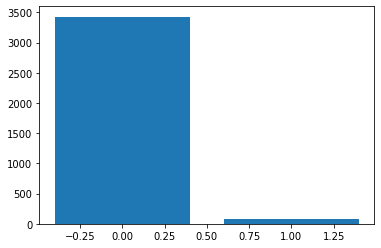

In [ ]:
plt.bar(x=data["Euroskepticism_Score"].value_counts().index, height=data["Euroskepticism_Score"].value_counts().values)
plt.show()

In [ ]:
data[data["Euroskepticism_Score"] == 1]["Question_Text"].iloc[0]

'On 8 November 2012 Euratex sent a letter to Commissioner Karel de Gucht expressing the EU textile industrys concern over the possible  of negotiations between the EU and Canada. In recent years the EU textile industry has struggled with major problems in terms of  systematically serving as a bargaining chip for trade agreements with third countries. The recent agreement with Pakistan was very damaging for the EU textile industry. The CETA Canada-EU Trade Agreement does not currently provide the desirable reciprocity and will undoubtedly lead to further imbalance in the industry. The EU has always favoured double transformation as a way to obtain preferential origin. Canada has advocated the single transformation rule as its supply chain is included in the North American Free Trade Agreement and a substantial proportion of the supplies are made in Asia. The Canadian textile industry has little  to that of the EU. How does the Commission view this situation Given that Canada intends to 

In [ ]:
data[data["Euroskepticism_Score"] == 1]["Question_Text"].iloc[1]

'The Commission has launched detailed enquiries into the tax arrangements for ports in Belgium France and the Netherlands in order to make sure that they are in line with the EUs state aid rules. These enquiries which are at various stages  are a follow-up to a Commission questionnaire that was sent to Member States on tax arrangements for European ports. While the Commissions decision to  on a case-by-case basis is understandable it is astonishing that no detailed report has yet been published on the results of the study given that the questionnaire was sent to the Member States on 3 July 2013.  For the sake of transparency will the Commission make the results of the study publicly available or at the very least send them to Parliament In the light of the results of that study can the Commission confirm that no Member States other than those currently being subjected to detailed enquiries give ports special tax arrangements that can be considered state aid'

### Desc:
Here I'm confirming a notion I had that may be causing our poor performance - we see that we're creating a more balanced dataset by oversampling before we split into train and test (according to the previous BERT model). This is causing our model to know instances of the test before evaluation - causing high validation scores but extremeley low test accuracy scores.

In [ ]:
df = pd.read_csv('../bert/data/cleaned.csv')
list_classes = ['Euroskepticism_Score']
ratio = 0.35

display(df.head(5))
x = np.asarray(df.index).reshape(-1, 1)
y = df[list_classes]

x_resampled, y_resampled = imblearn.over_sampling.ADASYN(ratio).fit_resample(x, y) #this is where the imbalanced learning process happens
x_resampled, y_resampled = imblearn.combine.SMOTETomek().fit_resample(x, y)

freq_map = {}
for x in x_resampled:
    if x[0] in freq_map:
        freq_map[x[0]] += 1
    else:
        freq_map[x[0]] = 1
        
out = {k: v for k, v in sorted(freq_map.items(), key=lambda item: item[1], reverse=True)}
# print(out)


,Question_Text,Question_ID,Euroskepticism_Score,Nationalism_Score,Populism_Score,Question_Text_Lower
0,Further to the answer it gave to my Question E...,E-013527-13,0.0,0.0,0.0,further to the answer it gave to my question e...
1,In Italy as in many other Member States legal ...,E-001570-13,1.0,0.0,1.0,in italy as in many other member states legal ...
2,On 1 September 2013 Iraqi forces carried out a...,P-010965-13,0.0,0.0,0.0,on 1 september 2013 iraqi forces carried out a...
3,In the Work Programme of the Agency for the Co...,E-011939-13,0.0,0.0,0.0,in the work programme of the agency for the co...
4,Identification marking on foods which are avai...,E-003034-13,0.0,0.0,0.0,identification marking on foods which are avai...


/Users/nicklin/opt/anaconda3/envs/defaultenv/lib/python3.10/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.35 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [ ]:
longest_question = df['Question_Text'].str.split().map(lambda x: len(x)).max()
longest_question

510

### Desc:

Now I'm going to attempt to clean the data a bit by tokenizing, removing stopwords, stemming, lemmatizing, etc. Here I'll also clean out punctuation but we may want to revise this step later if we decide to split sentences up.

In [ ]:
import nltk
from nltk.corpus import treebank 
from nltk.tree import Tree
import string
import re
import os
import argparse

In [ ]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = text.strip()
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

def lemmatizer(text):
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    return text

def clean_text(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return ' '.join(text)

In [ ]:
data['clean_text'] = data['Question_Text'].apply(lambda x : clean_text(x))

In [ ]:
data.head(5)

,Question_Text,Question_ID,Euroskepticism_Score,clean_text
0,The introduction of smart meters is required u...,E-1597/09,0,The introduction smart meter required Directiv...
1,I have been informed in connection with the hu...,P-2182/04,0,I informed connection human minority right sit...
2,A few days ago the Italian press reported an a...,E-3260/07,0,A day ago Italian press reported alleged case ...
3,In 2000 the EKAB air rescue fleet was set up w...,E-1822/03,0,In EKAB air rescue fleet set funding provided ...
4,Is the Commission aware of the UK Citizens Adv...,E-3867/03,0,Is Commission aware UK Citizens Advice Bureaus...


### Desc:

Here I'm splitting the data into train, test, and validation datasets. We can use these as baselines moving forward (no further need to touch any other datasets).

For reference, we should use merged_scores_train to do any imbalanced dataset resolving and rely on using validation and test as ways for benchmarks. 

In [ ]:
train, test = model_selection.train_test_split(data, test_size = 0.2, random_state=42, shuffle=True)
train, validation = model_selection.train_test_split(train, test_size = 0.1, random_state=42, shuffle=True)

In [ ]:
print(train.shape)
print(validation.shape)
print(test.shape)

(2525, 4)
(281, 4)
(702, 4)


In [ ]:
train.to_csv("../data/split_merged_scores/merged_scores_train.csv")
validation.to_csv("../data/split_merged_scores/merged_scores_validation.csv")
test.to_csv("../data/split_merged_scores/merged_scores_test.csv")

### Desc:

Now I want to use an oversampling technique on the data. However, I need a way to represent a full question as a float in order to provide the imblearn package with an "embedding" or "representation" of my sentence. Here I'll use doc2vec to create an embedding of each document.

In [ ]:
train = pd.read_csv("../data/split_merged_scores/merged_scores_train.csv", index_col=0)
train.head(5)

,Question_Text,Question_ID,Euroskepticism_Score,clean_text
487,The EU market is being penetrated to an ever-i...,H-0704/07,0,The EU market penetrated everincreasing extent...
383,High-voltage power lines 380 kV have been erec...,E-002811-14,0,Highvoltage power line kV erected area Settevi...
1328,On 13 September Radio Free Europe reported tha...,E-009632/2011,0,On September Radio Free Europe reported Europe...
2917,Five years ago a pan-European multilingual pl...,E-014338-13,0,Five year ago panEuropean multilingual platfor...
1042,With regard to the Raphael Programmes call for...,P-4055/98,0,With regard Raphael Programmes call proposal H...


In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train['clean_text'])]
model = Doc2Vec(documents, vector_size=1, window=2, min_count=1, workers=4)

In [ ]:
train['doc2vec'] = train["clean_text"].apply(lambda x : model.infer_vector(x.split(" "))[0])
train['index'] = train.index
train.head(5)

,Question_Text,Question_ID,Euroskepticism_Score,clean_text,doc2vec,index
487,The EU market is being penetrated to an ever-i...,H-0704/07,0,The EU market penetrated everincreasing extent...,-0.158460,487
383,High-voltage power lines 380 kV have been erec...,E-002811-14,0,Highvoltage power line kV erected area Settevi...,0.453566,383
1328,On 13 September Radio Free Europe reported tha...,E-009632/2011,0,On September Radio Free Europe reported Europe...,0.049087,1328
2917,Five years ago a pan-European multilingual pl...,E-014338-13,0,Five year ago panEuropean multilingual platfor...,-0.653505,2917
1042,With regard to the Raphael Programmes call for...,P-4055/98,0,With regard Raphael Programmes call proposal H...,0.376559,1042


### Desc:
Now let's go ahead and create an oversampled version of the data

In [ ]:
X = train[['index', 'doc2vec']]
y = train['Euroskepticism_Score']

In [ ]:
# oversampler = imblearn.RandomOverSampler(sampling_strategy=0.35)
ratio = 0.35
x_resampled, y_resampled = imblearn.over_sampling.ADASYN(ratio).fit_resample(X, y)

/Users/nicklin/opt/anaconda3/envs/defaultenv/lib/python3.10/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.35 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [ ]:
print(x_resampled)

      index   doc2vec
0       487 -0.158460
1       383  0.453566
2      1328  0.049087
3      2917 -0.653505
4      1042  0.376559
...     ...       ...
3342   3296 -0.082722
3343   3091  0.047377
3344   3252 -0.212771
3345   3230 -0.335309
3346   3199 -0.218456

[3347 rows x 2 columns]


In [ ]:
resampled_df = pd.DataFrame(x_resampled)
resampled_df.head(5)

,index,doc2vec
0,487,-0.158460
1,383,0.453566
2,1328,0.049087
3,2917,-0.653505
4,1042,0.376559


In [ ]:
X_resampled_final = train.merge(resampled_df, on='index')
X_resampled_final = X_resampled_final.drop("index", axis=1)

In [ ]:
X_resampled_final.to_csv("../data/oversampled_data/train_adasyn_oversample.csv")

In [ ]:
X_resampled_final.head(5)

,Question_Text,Question_ID,Euroskepticism_Score,clean_text,doc2vec_x,doc2vec_y
0,The EU market is being penetrated to an ever-i...,H-0704/07,0,The EU market penetrated everincreasing extent...,-0.158460,-0.158460
1,High-voltage power lines 380 kV have been erec...,E-002811-14,0,Highvoltage power line kV erected area Settevi...,0.453566,0.453566
2,On 13 September Radio Free Europe reported tha...,E-009632/2011,0,On September Radio Free Europe reported Europe...,0.049087,0.049087
3,Five years ago a pan-European multilingual pl...,E-014338-13,0,Five year ago panEuropean multilingual platfor...,-0.653505,-0.653505
4,With regard to the Raphael Programmes call for...,P-4055/98,0,With regard Raphael Programmes call proposal H...,0.376559,0.376559


### NOTE:

This is a separate section where I merely keep stopwords in the clean text version of the datasets.

In [ ]:
def clean_text_keep_stopwords(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = lemmatizer(text)
    return ' '.join(text)

In [ ]:
train_data = pd.read_csv("../data/split_merged_scores/merged_scores_train.csv", index_col=0)
validation_data = pd.read_csv("../data/split_merged_scores/merged_scores_validation.csv", index_col=0)
test_data = pd.read_csv("../data/split_merged_scores/merged_scores_test.csv", index_col=0)
oversampled_data = pd.read_csv("../data/oversampled_data/train_adasyn_oversample.csv", index_col=0)

In [ ]:
train_data["clean_text_with_stopwords"] = train_data["Question_Text"].apply(lambda x : clean_text_keep_stopwords(x))
validation_data["clean_text_with_stopwords"] = validation_data["Question_Text"].apply(lambda x : clean_text_keep_stopwords(x))
test_data["clean_text_with_stopwords"] = test_data["Question_Text"].apply(lambda x : clean_text_keep_stopwords(x))
oversampled_data["clean_text_with_stopwords"] = oversampled_data["Question_Text"].apply(lambda x : clean_text_keep_stopwords(x))

In [ ]:
train_data.head(5)

,Question_Text,Question_ID,Euroskepticism_Score,clean_text,Parties,Country,clean_text_with_stopwords
487,The EU market is being penetrated to an ever-i...,H-0704/07,0,The EU market penetrated everincreasing extent...,NaN,Slovakia,The EU market is being penetrated to an everin...
383,High-voltage power lines 380 kV have been erec...,E-002811-14,0,Highvoltage power line kV erected area Settevi...,PPE,Italy,Highvoltage power line kV have been erected in...
1328,On 13 September Radio Free Europe reported tha...,E-009632/2011,0,On September Radio Free Europe reported Europe...,EFD,Italy,On September Radio Free Europe reported that t...
2917,Five years ago a pan-European multilingual pl...,E-014338-13,0,Five year ago panEuropean multilingual platfor...,NI,Spain,Five year ago a panEuropean multilingual platf...
1042,With regard to the Raphael Programmes call for...,P-4055/98,0,With regard Raphael Programmes call proposal H...,PPE,United Kingdom,With regard to the Raphael Programmes call for...


In [ ]:
train_data.to_csv("../data/split_merged_scores/merged_scores_train.csv")
validation_data.to_csv("../data/split_merged_scores/merged_scores_validation.csv")
test_data.to_csv("../data/split_merged_scores/merged_scores_test.csv")
oversampled_data.to_csv("../data/oversampled_data/train_adasyn_oversample.csv")